In [13]:
%%capture
%pip install osmnx
%pip install --upgrade osmnx
%pip install hdx-python-api


In [45]:
import osmnx as ox
import os
import geopandas as gpd
import pandas as pd
import requests
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings("ignore", category=FutureWarning, module='osmnx')

In [19]:
!git clone https://github.com/zippyzippy0/miniproject.git


fatal: destination path 'miniproject' already exists and is not an empty directory.


In [20]:
import sys
sys.path.append("/content/miniproject")  # repo root, contains fynesse/
import fynesse


In [24]:
import os, subprocess, importlib, sys

def load_repo(repo, module):
    local = repo.split("/")[-1]
    if not os.path.exists(local):
        subprocess.run(["git", "clone", f"https://github.com/{repo}.git"], check=True)
    else:
        subprocess.run(["git", "-C", local, "pull"], check=True)
    if os.path.join(local) not in sys.path:
        sys.path.insert(0, local)
    mod = importlib.import_module(module)
    importlib.reload(mod)
    return mod

# usage
fynesse = load_repo("zippyzippy0/miniproject", "fynesse")


<Axes: >

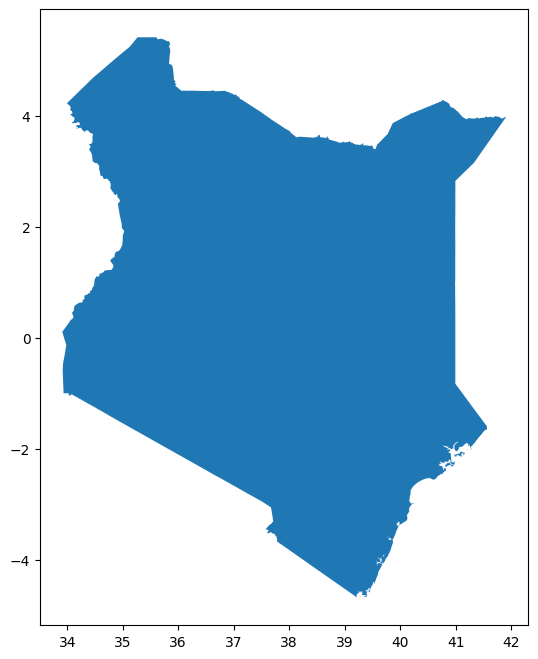

In [49]:
kenya = gpd.read_file("/content/drive/MyDrive/miniproject/data/ken_adm_iebc_20191031_shp/ken_admbnda_adm0_iebc_20191031.shp")

kenya.plot(figsize=(10,8))

<Axes: >

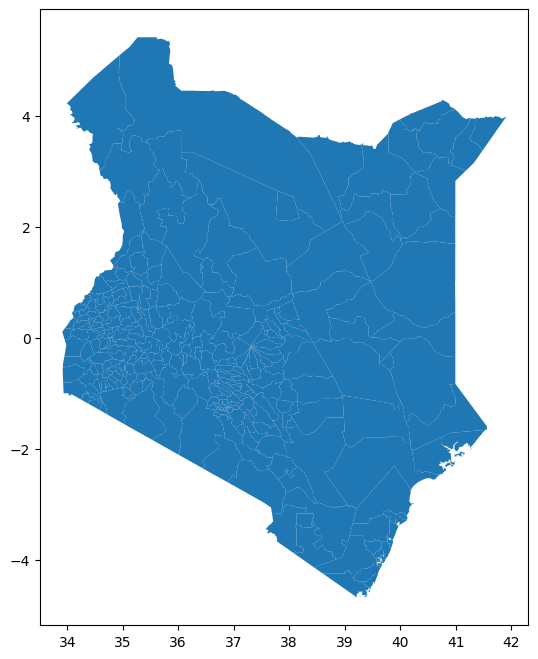

In [52]:
subcounties = gpd.read_file("/content/drive/MyDrive/miniproject/data/ken_adm_iebc_20191031_shp/ken_admbnda_adm2_iebc_20191031.shp")

subcounties.plot(figsize=(10,8))

<Axes: >

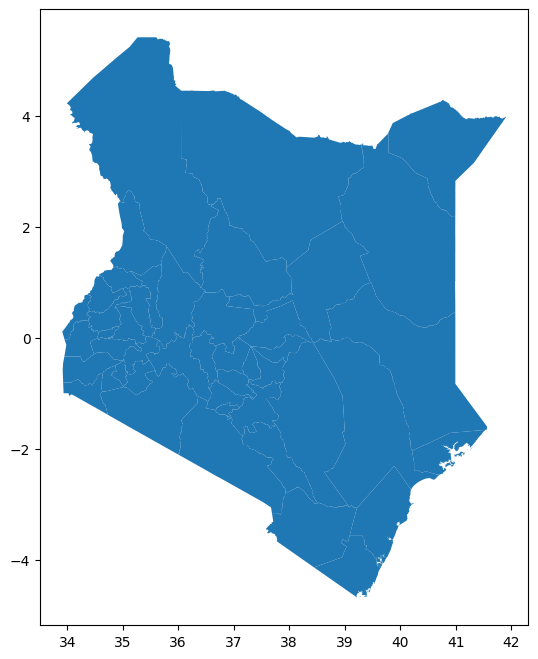

In [53]:
counties = gpd.read_file("/content/drive/MyDrive/miniproject/data/ken_adm_iebc_20191031_shp/ken_admbnda_adm1_iebc_20191031.shp")

counties.plot(figsize=(10,8))

In [72]:
import requests
import geopandas as gpd
from shapely.geometry import Point

def fetch_osm_amenities(bbox, amenities):
    # bbox = [south, west, north, east]
    # amenities = ["school", "hospital"]
    query = f"""
    [out:json][timeout:180];
    (
      node["amenity"~"{'|'.join(amenities)}"]({bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
      way["amenity"~"{'|'.join(amenities)}"]({bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
      relation["amenity"~"{'|'.join(amenities)}"]({bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
    );
    out center;
    """
    url = "http://overpass-api.de/api/interpreter"
    try:
        response = requests.get(url, params={"data": query}, timeout=180)
        response.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
        data = response.json()["elements"]

        features = []
        for el in data:
            if "lat" in el and "lon" in el:
                lat, lon = el["lat"], el["lon"]
            elif "center" in el:
                lat, lon = el["center"]["lat"], el["center"]["lon"]
            else:
                continue
            features.append({
                "name": el["tags"].get("name", "Unknown"),
                "amenity": el["tags"].get("amenity", "Unknown"),
                "geometry": Point(lon, lat)
            })

        if not features:
            return gpd.GeoDataFrame(columns=["name", "amenity", "geometry"], geometry="geometry", crs="EPSG:4326")

        return gpd.GeoDataFrame(features, crs="EPSG:4326")

    except requests.exceptions.RequestException as e:
        print(f"Overpass API request failed: {e}")
        print(f"Query: {query}")
        if 'response' in locals() and response is not None:
            print(f"Response text: {response.text}")
        return gpd.GeoDataFrame(columns=["name", "amenity", "geometry"], geometry="geometry", crs="EPSG:4326")
    except requests.exceptions.JSONDecodeError as e:
        print(f"Failed to decode JSON response from Overpass API: {e}")
        if 'response' in locals() and response is not None:
            print(f"Response text: {response.text}")
        return gpd.GeoDataFrame(columns=["name", "amenity", "geometry"], geometry="geometry", crs="EPSG:4326")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        if 'response' in locals() and response is not None:
            print(f"Response text: {response.text}")
        return gpd.GeoDataFrame(columns=["name", "amenity", "geometry"], geometry="geometry", crs="EPSG:4326")

In [63]:
kenya_bbox = [-4.72, 33.89, 5.33, 41.89]
counties = gpd.read_file("/content/drive/MyDrive/miniproject/data/ken_adm_iebc_20191031_shp/ken_admbnda_adm1_iebc_20191031.shp")
points = fetch_osm_amenities(kenya_bbox, ["school", "hospital"])

kenya_union = counties.unary_union
points = points[points.within(kenya_union)]

/tmp/ipython-input-1055369420.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  kenya_union = counties.unary_union


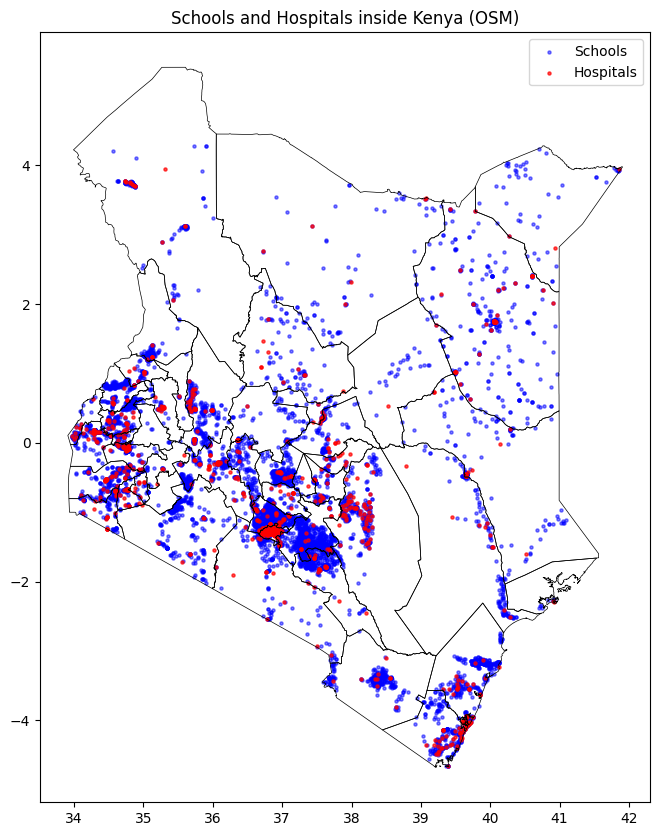

In [64]:
fig, ax = plt.subplots(figsize=(12,10))
counties.boundary.plot(ax=ax, color="black", linewidth=0.5)
points[points["amenity"]=="school"].plot(ax=ax, color="blue", markersize=5, alpha=0.5, label="Schools")
points[points["amenity"]=="hospital"].plot(ax=ax, color="red", markersize=5, alpha=0.7, label="Hospitals")
plt.legend()
plt.title("Schools and Hospitals inside Kenya (OSM)")
plt.show()

/tmp/ipython-input-1708014273.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  county_union = county.unary_union


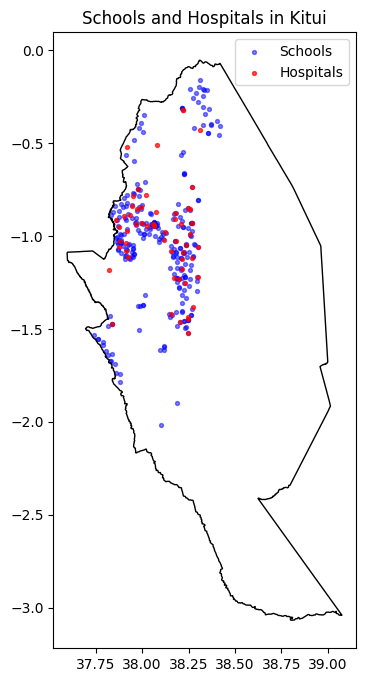

In [66]:
county_name = "Kitui"
county = counties[counties["ADM1_EN"] == county_name]
bbox = county.total_bounds
points = fetch_osm_amenities([bbox[1], bbox[0], bbox[3], bbox[2]], ["school", "hospital"])

county_union = county.unary_union
points = points[points.within(county_union)]

fig, ax = plt.subplots(figsize=(10,8))
county.boundary.plot(ax=ax, color="black", linewidth=1)
points[points["amenity"]=="school"].plot(ax=ax, color="blue", markersize=8, alpha=0.5, label="Schools")
points[points["amenity"]=="hospital"].plot(ax=ax, color="red", markersize=8, alpha=0.7, label="Hospitals")
plt.legend()
plt.title(f"Schools and Hospitals in {county_name}")
plt.show()

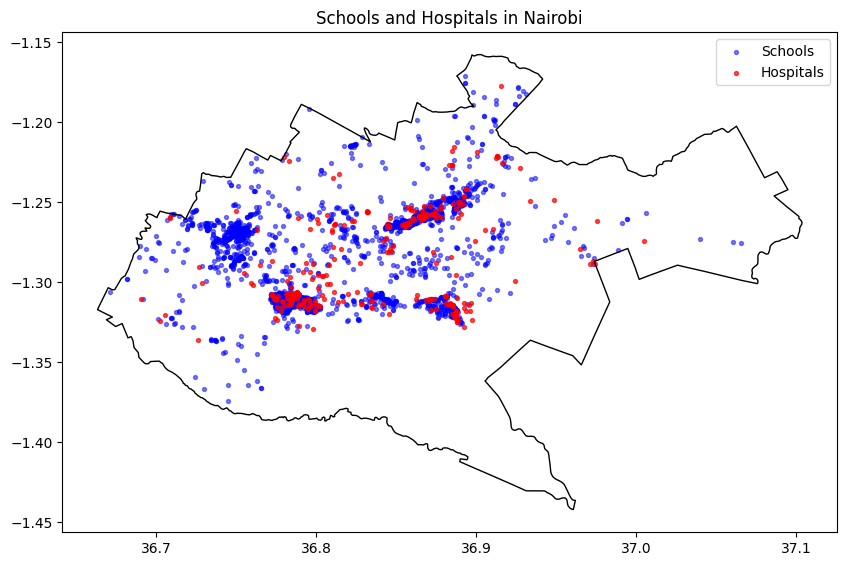

In [74]:
import matplotlib.pyplot as plt
import geopandas as gpd

county_name = "Nairobi"
county = counties[counties["ADM1_EN"] == county_name]

if not county.empty:
    minx, miny, maxx, maxy = county.geometry.iloc[0].bounds

    bbox = [miny, minx, maxy, maxx]

    points = fetch_osm_amenities(bbox, ["school", "hospital"])
    if not points.empty:
        county_union = county.geometry.union_all()
        points = points[points.within(county_union)]

        fig, ax = plt.subplots(figsize=(10,8))
        county.boundary.plot(ax=ax, color="black", linewidth=1)
        points[points["amenity"]=="school"].plot(ax=ax, color="blue", markersize=8, alpha=0.5, label="Schools")
        points[points["amenity"]=="hospital"].plot(ax=ax, color="red", markersize=8, alpha=0.7, label="Hospitals")
        plt.legend()
        plt.title(f"Schools and Hospitals in {county_name}")
        plt.show()
    else:
        print(f"No amenities data fetched for {county_name}.")
else:
    print(f"County '{county_name}' not found.")